# Ablation Studies in Simple Environment

PE-UCRL was compared against 3 types of ablation:
(1) The shield was removed.
(2) Action prining was removed.
(3) An unsafe baseline with both (1) and (2).

The environment is one of the simplest non-trivial environments.
There are 3 cells.
There are 3 intracellular states (i.e. 27 states).
There are 3 intracellular actions (i.e. 27 actions).

In more detail, the intracellular states correspond to a spectrum from left to right (e.g. political polarization).
Each intracellular action can either turn the intracellular state 1 degree more right or 1 degree more left or remain at the current degree (e.g. news recommendations that influence a user one way or another).
The initial state is the lefternmost and the initial policy for the RL agent is to remain there.
The higher rewards exist around the right end.
The total reward is nonlinear in the contributions from each cell.
The reward function is known to the RL agent from initialisation.
There is one regulator (e.g. a moderator), which is very likely to report side effects as along as they are not in the righternmost intracellular state.
There is one cell label (it corresponds to a child using the recommender engine).

## Importing
Only for drawing the plots.
Readers, please skip to the next section.

In [1]:
super_path = 'results/more_simple_ablations/'

In [2]:
import os
import pandas as pd
import seaborn as sns
sns.set_theme()
dir_set = set(os.listdir(super_path))
dir_set -= {'metadata.txt'}
data_set = [pd.DataFrame()] * len(dir_set)
for i, dir in enumerate(dir_set):
    data_set[i] = pd.read_csv(super_path + dir + '/data.csv')
data = pd.concat(data_set)


## Analysis
We plot the side effects incidence and the reward against time.
Each experiment was repeated 20 times and it is the mean and the standard devaition that are represented in the plots.

In [3]:
data = data.replace(
    {
        'P>=1 [ G n<=2 ] & P>=1 [ G n_children<=0]': 'simple',
        'P>=1 [ G n<=2 ] & P>=1 [ G n_children<=0] & P>=0.80 [ F<=20 n<=1 ]': 'advanced',
    }
)

We considered two different regulatory constraints, a simple and an advanced one, see above.
```n<=2``` means that at most 2 cells are allowed to experience adverse side effects. ```n_children<=0``` means that no children are allowed to experience adverse side effects.

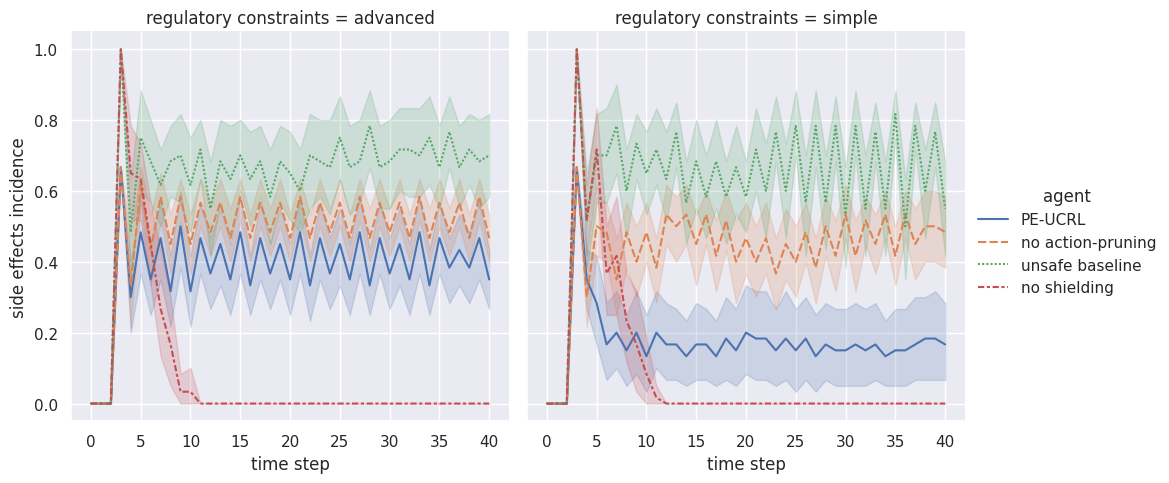

In [8]:
sns.relplot(
    data=data,
    kind='line',
    x='time step',
    y='side effects incidence',
    hue='agent',
    style='agent',
    col='regulatory constraints',
)

Above, side effects incidence is plotted against time.
- First, note that the advanced regulatory constraints yield a higher side effects incidence than the simple regulatory constraints! My hypothesis is that there is something odd with how the interval MDP engine in PRISM deals with the ```F<=``` operator. From now on, we will be focussing on the simple regulatory constraints.
- As expected, only the shielded algorithms keep the side effects at acceptable levels throughout the run.
- As expected, action-pruning makes the side effects go down over time.
- Contrary to my hope, PE-UCRL struggles to make the side effects go down to zero in a reliable manner. Some times it manages and sometimes it does not as indicated by the large standard deviation. My hypothesis is that there is little incentive for the agent to explore states where it is unknown whether side effects occur. This could be helped by adding reward shaping.[^footnote] I have been aware that this could be an issue for a long time.

[^footnote]: Suggestion. The reward shaping should be a penalty. The penalty should be a monotonically increasing function of $\log(t)/\max\{1, N(s)\}$, where $t$ is the time step and $N(s)$ is the visitation count for state $s$.

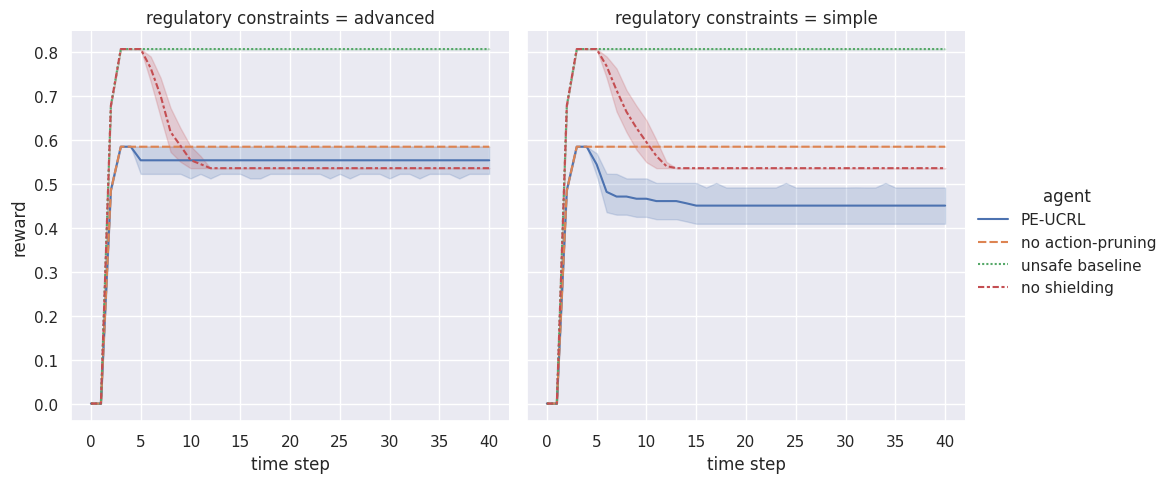

In [7]:
sns.relplot(
    data=data,
    kind='line',
    x='time step',
    y='reward',
    hue='agent',
    style='agent',
    col='regulatory constraints',
)

Above, reward is plotted against time.

- All algorithms converge quickly. The reason is the simplicity of the environment. To check that estimates of the transition function are refined adequately,[^footnote] a more complex environment would be required. For example, such an environment could contain probabilistic transitions. (The current environment is fully deterministic.)
- As expected, the unsafe baseline acquires more reward, but that is becasue it is not taking any safety into account.
- Somewhat unexpectedly, the 'no shielding' algorithm converges to a lower value than the 'no action-pruning'. This depends on the environment, but my intuition is that for most envirionments the reverse should be true.
- Annoyingly, PE-UCRL does not reliably converge to the same value as the 'no action-pruning' ablation. Just as it does not reliably get the side effects down to zero, there is a large standard deviation here. The problem is likely the same.

[^footnote]: The algorithms do still perform exploration until finding a high immediate reward. More complex longterm dependencies might also be a way to make the environment more interesting from a learning perspective. It still performs some learning such as pruning actions.

In [63]:
time_complexities = pd.DataFrame(
    {
        'PE-UCRL': data[(data['agent'].values == 'PE-UCRL') & (data['regulatory constraints'] == 'simple')]['off policy time'],
        'no action-pruning': data[(data['agent'].values == 'no action-pruning') & (data['regulatory constraints'] == 'simple')]['off policy time'],
        'no shielding': data[(data['agent'].values == 'no shielding') & (data['regulatory constraints'] == 'simple')]['off policy time'],
        'unsafe baseline': data[(data['agent'].values == 'unsafe baseline') & (data['regulatory constraints'] == 'simple')]['off policy time'],
    }
)
table = pd.DataFrame(
    {
        'off policy phases (number of)': time_complexities.count()/20,
        'mean time (s)': time_complexities.mean(),
        'std time (s)': time_complexities.std(),
    }
)
print(table)

                   off policy phases (number of)  mean time (s)  std time (s)
PE-UCRL                                     8.35       7.213369      0.629478
no action-pruning                           7.95       7.258263      0.747409
no shielding                                9.85       0.241674      0.087046
unsafe baseline                             7.20       0.271713      0.038197


Above, the time complexities for the off-policy phase is tabulated in seconds.[^footnote]

- As expected, shielding adds time to the off policy time. Much time, more than an order of magnitude.

[^footnote]: The statistics are calculated both over time steps and over different runs of the same agent.

## To Do
- [ ] Create more challenging environment.
- [ ] Test learning more thoroughly in this.
- [ ] Add reward shaping through penalties (might affect proofs).
- [ ] Add more interesting baselines, e.g. bounded KL divergence exploration.